This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [16]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
e1, e2=0.5, 4
enum='log3'
subj='subj01'
roi='V1'

# Load betas and experimental design information

In [4]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFcenter.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [34]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

In [35]:
bin_df

,sub,vroinames,ecc_bin,freq_lvl,names,betas,local_sf
0,subj01,V1,0.5-1.0 deg,0,annulus,1.386069,1.286699
1,subj01,V1,0.5-1.0 deg,0,forward spiral,1.829799,1.213111
2,subj01,V1,0.5-1.0 deg,0,pinwheel,1.678538,1.286699
3,subj01,V1,0.5-1.0 deg,0,reverse spiral,2.521147,1.213111
4,subj01,V1,0.5-1.0 deg,1,annulus,2.078130,2.358948
...,...,...,...,...,...,...,...
67,subj01,V1,2.0-4.0 deg,4,reverse spiral,2.835035,4.064872
68,subj01,V1,2.0-4.0 deg,5,annulus,2.226701,7.508372
69,subj01,V1,2.0-4.0 deg,5,forward spiral,2.125459,7.549048
70,subj01,V1,2.0-4.0 deg,5,pinwheel,1.856845,7.508372


## Sanity check: Datapoints only

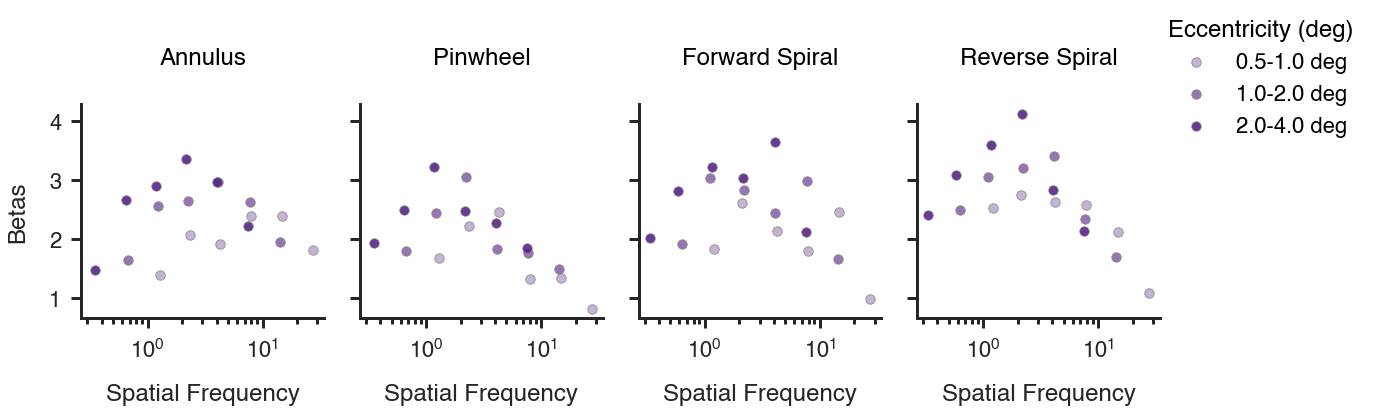

In [32]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')[:1]
vis1D.plot_datapoints(bin_df, 'local_sf', 'betas', hue='ecc_bin', hue_order=bin_labels, 
                      col='names', col_order=stim_classes, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=ecc_colors)

# 2. Fitting log Gaussian curves for every eccentricity bin

In [49]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [68]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88352
**epoch no.49 loss: 2.72505
**epoch no.99 loss: 1.21305
**epoch no.100: Finished! final params {'slope': 1.446, 'mode': 1.623, 'sigma': 2.2}
Elapsed time: 0.04 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.6844
**epoch no.49 loss: 4.0873
**epoch no.99 loss: 2.05644
**epoch no.100: Finished! final params {'slope': 1.45, 'mode': 1.531, 'sigma': 1.924}
Elapsed time: 0.04 sec 

2.0-4.0 deg
**epoch no.0 loss: 7.15409
**epoch no.49 loss: 5.15093
**epoch no.99 loss: 3.23765
**epoch no.100: Finished! final params {'slope': 1.147, 'mode': 1.566, 'sigma': 2.422}
Elapsed time: 0.04 sec 
